### Peal fitting with Radial/azimuthal data


version 2.0.0  April 24, 2021 JS
version 1.0.0  January 10, 2021 JS 

#### This script consists of 2 parts: 1) reading .pkl data. 2) fitting and save as pandas file

#### meridional 004 deconvolution (radial direction )

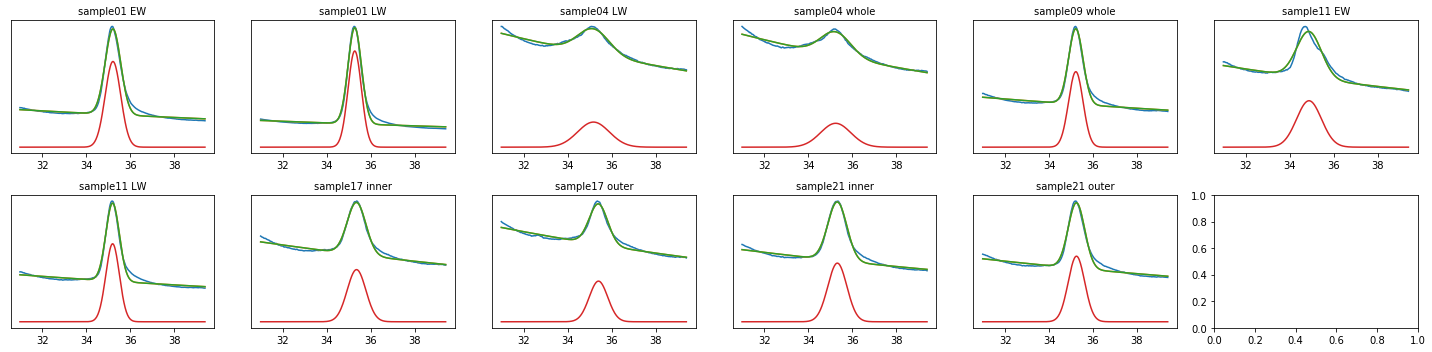

In [1]:
### XRAY_28_DES_2020
### vertical axis is converted to 2-theta axis by bilinear interpolation.
### then coverted to sphere and polar coordinate and save data as tif  ./results/sphere and pandas table  ./results/polar
### figure containing spherical diagram and profiles saved in ./results/figure
### (004) and equatorial profile / radial and azimuthal integration saved in ,/results/profile
###
### the following script reads profile and performs peak fitting.

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import cv2
from tqdm import tqdm
import pandas as pd
from common.xray import *
from scipy.optimize import curve_fit
import openpyxl
pd.options.display.precision = 2
%matplotlib inline

profile_path='./results/profile'
sample_names=sorted([filename[:-15] for filename in os.listdir(profile_path) if filename.endswith('004_radial.pkl')])
radial_004_names=sorted([filename for filename in os.listdir(profile_path) if filename.endswith('004_radial.pkl')])
azimuth_004_names=sorted([filename for filename in os.listdir(profile_path) if filename.endswith('004_azimuth.pkl')])
radial_eq_names=sorted([filename for filename in os.listdir(profile_path) if filename.endswith('eq_radial.pkl')])
azimuth_eq_names=sorted([filename for filename in os.listdir(profile_path) if filename.endswith('eq_azimuth.pkl')])
current_path=os.getcwd()
t_dir=os.path.join(current_path, 'results/figure/peakfit')

def func(x, a, b, c, d, e):
    return a * np.exp(-(b-x)**2/c**2) + d * np.exp(-x/e)
def gaussf(x, a, b, c):
    return a * np.exp(-(b-x)**2/c**2) 

radial_004=[]
sp_num=len(sample_names)
n_cols=6
n_rows=round(sp_num/n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,5))

for i, fl_name in enumerate(radial_004_names):
    df_from_pkl = pd.read_pickle(os.path.join(profile_path,fl_name)) # from profile
    x=df_from_pkl.index.values
    y=df_from_pkl.values
    y_max=df_from_pkl.values.max()
    y_min=df_from_pkl.values.min()


    p0=[y_max-y_min,34.6,1,(y_max-y_min)/5, 30]
    popt, pcov = curve_fit(func, x,y,p0)
    y_pred = func(x, *popt)
    
    q,mod=divmod(i,n_cols)

    axes[q,mod].plot(x,y)
    axes[q,mod].set_title(fl_name.split('_')[0]+' '+fl_name.split('_')[1], fontsize=10)
    axes[q,mod].plot(x,y_pred)
    axes[q,mod].plot(x,y_pred)
    axes[q,mod].plot(x,gaussf(x,popt[0],popt[1],popt[2]))
    axes[q,mod].set(yticklabels=[])  # remove the tick labels
    axes[q,mod].tick_params(left=False) 
    
    radial_004.append(popt)

fig.tight_layout()
#plt.savefig(os.path.join(t_dir,'(004)_line_broadening'), dpi=300)
plt.show()           
df_rad_004=pd.DataFrame(radial_004,index=sample_names,columns=['(004) amplitude','2-theta_(004)','sigma_(004)','bg_A_(004)',
                                                                   'bg_sigma_(004)'])
#with pd.ExcelWriter(res, engine="openpyxl", mode="a") as writer:
#     df.to_excel(writer, sheet_name='(004)_line_broadening')

#### deconvolution of equatorial diffraction profiles

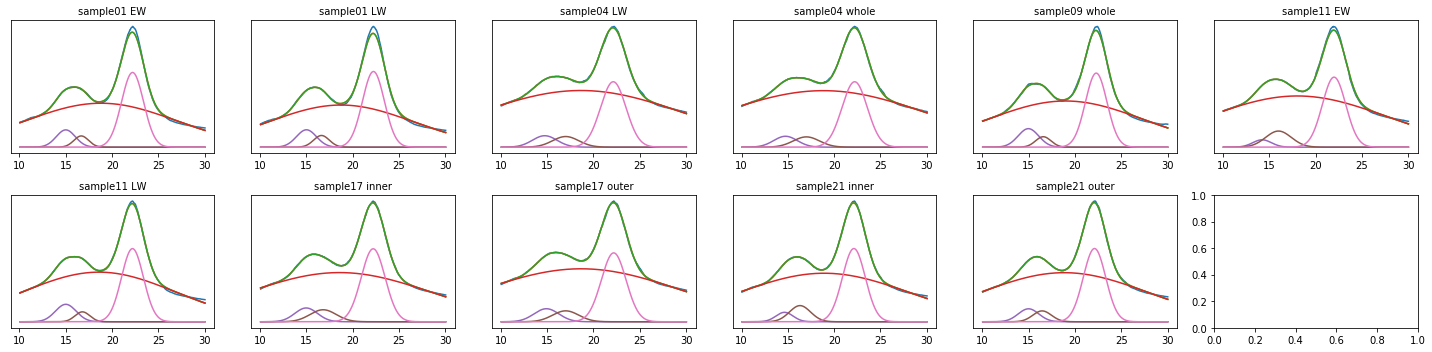

In [2]:
# equatorial radial profile
radial_eq=[]
sp_num=len(radial_eq_names)
n_cols=6
n_rows=round(sp_num/n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,5))

def func(x, a, b, c, d, e, f, g, h, i, j, k, l):
    return a * np.exp(-(b-x)**2/c**2) + d * np.exp(-(e-x)**2/f**2) + g * np.exp(-(h-x)**2/i**2)+j * np.exp(-(k-x)**2/l**2)



for i, fl_name in enumerate(radial_eq_names):
    df_from_pkl = pd.read_pickle(os.path.join(profile_path,fl_name)) # from profile
    x=df_from_pkl.index.values[157:867] # 10 degree to 30 degree
    y=df_from_pkl.values[157:867] # 10 degree to 30 degree
    y_max=df_from_pkl.values.max()
    y_min=df_from_pkl.values.min()
    am_max=df_from_pkl.values[357:667].min()
    I002=(y_max-y_min)*0.6
    p0=[0.2*I002,14.6,2,0.2*I002, 16.4, 2,I002,22.8,2,0.7*am_max,18.5,10]
    lower_bounds=[0.1*I002,14,1,0.1*I002,16,1,0.4*I002,22,1,0.5*am_max,18,10]
    upper_bounds=[0.3*I002,15,2,0.3*I002,17,2,1.2*I002,23,2,am_max,19,20]
    popt, pcov = curve_fit(func, x,y,p0,bounds=(lower_bounds,upper_bounds), maxfev = 1000000)
    y_pred = func(x, *popt)

    q,mod=divmod(i,n_cols)

    axes[q,mod].plot(x,y)
    axes[q,mod].set_title(fl_name.split('_')[0]+' '+fl_name.split('_')[1], fontsize=10)
    axes[q,mod].plot(x,y_pred)
    axes[q,mod].plot(x,y_pred)
    for k in list(range(4)):
        axes[q,mod].plot(x,gaussf(x,popt[3*(k-1)+0],popt[3*(k-1)+1],popt[3*(k-1)+2]))
    axes[q,mod].set(yticklabels=[])  # remove the tick labels
    axes[q,mod].tick_params(left=False) 
       
    radial_eq.append(popt)

fig.tight_layout()
#plt.savefig(os.path.join(t_dir,'equatorial_line_broadening'), dpi=300)
plt.show()       

df_rad_eq=pd.DataFrame(radial_eq,index=sample_names,columns=['(-110)','2-theta_(-110)','sigma_(-110)','(110)','2-theta_(110)',
                                                                'sigma_(110)', '(200)','2-theta_(200)','sigma_(200)',
                                                                'amorph','2-theta_amorph','sigma_amorph'])
#with pd.ExcelWriter(res, engine="openpyxl", mode="a") as writer:
#     df.to_excel(writer, sheet_name='equatorial_line_broadening')

### deconvolution of meridional (004) azimuthal profile (measure of MFA)

#### profile visualization

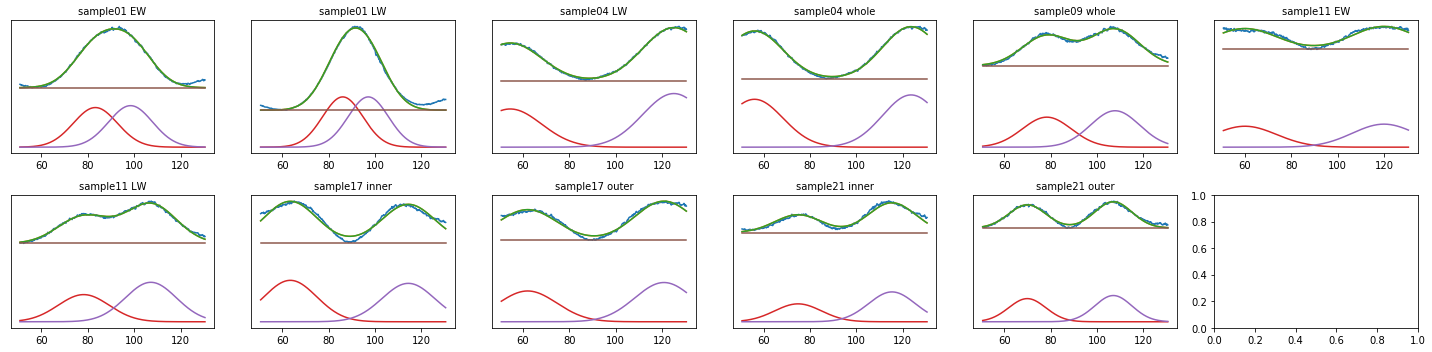

In [3]:
sp_num=len(azimuth_004_names)
n_cols=6
n_rows=round(sp_num/n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,5))

def bgf(x,a):
    return x*0+a

# list(np.where(x==40)[0]),list(np.where(x==140)[0])
    
# azimuthal profile
azimuth_004=[]
for i, fl_name in enumerate(azimuth_004_names):
    df_from_pkl = pd.read_pickle(os.path.join(profile_path,fl_name)) # from profile
    x=df_from_pkl.index.values[184:632]
    y=df_from_pkl.values[184:632]
    y_max=df_from_pkl.values[184:632].max()
    y_min=df_from_pkl.values[184:632].min()
    def func(x, a, b, c, d, e, f):
        return a * np.exp(-(b-x)**2/c**2) + d * np.exp(-(e-x)**2/c**2) + f
    I004=(y_max-y_min)
    
    p0=[I004,70, 5, I004, 110, y_min]
    lower_bounds=[0.6*I004, 50, 2, 0.6*I004, 91, 0.3*y_min]
    upper_bounds=[1*I004, 95, 30, 1*I004, 130,  y_min]
    
    popt, pcov = curve_fit(func, x,y, p0,bounds=(lower_bounds,upper_bounds), maxfev = 100000)
    y_pred = func(x, *popt)
    
    q,mod=divmod(i,n_cols)
    
    axes[q,mod].plot(x,y)
    axes[q,mod].set_title(fl_name.split('_')[0]+' '+fl_name.split('_')[1], fontsize=10)
    axes[q,mod].plot(x,y_pred)
    axes[q,mod].plot(x,y_pred)
    
    axes[q,mod].plot(x,gaussf(x,popt[0],popt[1],popt[2]))
    axes[q,mod].plot(x,gaussf(x,popt[3],popt[4],popt[2]))
    axes[q,mod].plot(x,bgf(x,popt[5]))
    
    axes[q,mod].set(yticklabels=[])  # remove the tick labels
    axes[q,mod].tick_params(left=False) 
    
    azimuth_004.append(popt)
fig.tight_layout()
plt.savefig(os.path.join(current_path, 'MFA_(004).png'), dpi=300)
plt.show()       


pd.options.display.precision = 2
df_az_004=pd.DataFrame(azimuth_004, index=sample_names,columns=['(004)_1','azim_1_(004)','sigma_az_(004)', '(004)_2', 
                                                                     'azim_2_(004)','bg_az_(004)'])
df_az_004['MFA(degree)']=(df_az_004['azim_2_(004)']-df_az_004['azim_1_(004)'])/2
df_az_004['MFA_std']=df_az_004['sigma_az_(004)'].values
#with pd.ExcelWriter(res, engine="openpyxl", mode="a") as writer:
#     df.to_excel(writer, sheet_name='MFA_(004)')

save result

In [4]:
df_summary=pd.concat([df_rad_004, df_rad_eq, df_az_004], axis=1)
df_summary.insert(0, "sample_name", sample_names)
res = 'XRD_2.xlsx'
df_summary.to_excel(res)